# Chapter 04 - Cell Ranger Filtered UMAP

## Objective

In this chapter, we load all single-nucleus RNA-seq datasets required for benchmarking the **Singulator + FACS** and **Singulator + LeviCell** protocols. We also verify metadata consistency, perform basic integrity checks, and prepare the data objects for downstream analysis.

This includes:

- Locating the data on the shared filesystem (Iris)
- Loading raw count matrices (e.g., `filtered_feature_bc_matrix.h5` from 10X)
- Loading data into `AnnData` objects

## Data Source

The data for this benchmarking project is stored on the **Iris** HPC filesystem under:

`/data1/collab002/sail/isabl/datalake/prod/010/collaborators/SAIL/projects/singulator_debris_removal_and/experiments`

We will be working with the data under identifier `MB-4027_*`


In [2]:
%load_ext autoreload
%autoreload 2

## Core Imports

In [3]:
import os
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from typing import Callable, Dict, List, Union
import utils

## File Paths and Metadata

In [4]:
# Constants
DATA_DIR = "./data"
READ_ONLY_DIR = os.path.join(DATA_DIR, "read_only")
FIGURES_OUTPUT_DIR = os.path.join(DATA_DIR, "figures", "chapter_04_cell_ranger_filtered_umap_cell_typing")
RAW_FEATURE_BC_MATRIX_FILE_NAME = "raw_feature_bc_matrix.h5"

# Make sure figures output directory exists
os.makedirs(FIGURES_OUTPUT_DIR, exist_ok=True)

ANALYSIS_DIR = os.path.join(DATA_DIR, "analysis")
INPUT_ADATA_DIR = os.path.join(
    ANALYSIS_DIR, "adatas", "chapter_03_cell_ranger_filtered_basic_analysis"
)
OUTPUT_ADATA_DIR = os.path.join(ANALYSIS_DIR, "adatas", "chapter_05_cell_typing")

# Make sure output adata dir directory exists
os.makedirs(OUTPUT_ADATA_DIR, exist_ok=True)

# Sample metadata - in data/metadata.tsv
samples = {
    "SF_N": ("MB-4027_SF_N", "Normal Colon", "Singulator+FACS"),
    "SL_N": ("MB-4027_SL_N", "Normal Colon", "Singulator+LeviCell"),
    "SF_T": ("MB-4027_SF_T", "Tumor Colon", "Singulator+FACS"),
    "SL_T": ("MB-4027_SL_T", "Tumor Colon", "Singulator+LeviCell"),
    "SF_LN": ("MB-4027_SF_LN", "Normal Liver", "Singulator+FACS"),
    "SL_LN": ("MB-4027_SL_LN", "Normal Liver", "Singulator+LeviCell"),
}

# Color palette for plotting
protocol_color_palette = {
    "Singulator+FACS": "#AEC6CF",
    "Singulator+LeviCell": "#FFDAB9",
}

## Read in AnnDatas

### Individual AnnDatas

In [5]:
# Load AnnData objects
adatas = {}
adata_metadata = {}
adata_tissues = []

for key, (folder, tissue, protocol) in samples.items():
    file_path = os.path.join(INPUT_ADATA_DIR, f"{key}_adata.h5ad")
    adata = sc.read_h5ad(file_path)
    adatas[key] = adata
    adata_metadata[key] = (tissue, protocol)
    adata_tissues.append(tissue)
    print(f"{key}: {adata}")

SF_N: AnnData object with n_obs × n_vars = 7179 × 38606
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'pct_counts_ribosomal', 'total_counts_apoptosis', 'pct_counts_apoptosis', 'total_counts_housekeeping', 'pct_counts_housekeeping'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mitochondrial', 'ribosomal', 'apoptosis', 'housekeeping'
    layers: 'downsampled_umi'
SL_N: AnnData object with n_obs × n_vars = 7929 × 38606
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mitochondrial', 'pct_counts_mitochondrial', 'total_counts_ribosomal', 'pct_counts_ribosomal', 'total_counts_apoptosis', 'pct_counts_apoptosis', 'total_counts_housekeeping', 'pct_counts_housekeeping'
    var: 'gene_i

## Doublet Detection

In [6]:
def run_scrublet(adata: sc.AnnData) -> None:
    """
    Run Scrublet doublet detection on the given AnnData object.

    Parameters:
    adata (sc.AnnData): The AnnData object to analyze.
    """
    sc.pp.scrublet(
        adata,
        sim_doublet_ratio=2.0,
        expected_doublet_rate=0.06,
        knn_dist_metric="euclidean",
        log_transform=True,
        n_prin_comps=30,
        random_state=0,
    )  # From Roshan's workshop


for key, adata in adatas.items():
    print(f"Running Scrublet on {key}...")
    run_scrublet(adata)

Running Scrublet on SF_N...


adata.X seems to be already log-transformed.


Running Scrublet on SL_N...


adata.X seems to be already log-transformed.


Running Scrublet on SF_T...


adata.X seems to be already log-transformed.


Running Scrublet on SL_T...


adata.X seems to be already log-transformed.


Running Scrublet on SF_LN...


adata.X seems to be already log-transformed.


Running Scrublet on SL_LN...


adata.X seems to be already log-transformed.


### Preprocessing and Graph Computation

In [ ]:
# Use downsampled reads for analysis
for key, adata in adatas.items():
    adata.layers["raw_data"] = adata.X.copy()
    sc.pp.normalize_total(
        adata, target_sum=None, inplace=True
    )  # From both Roshan and sc-best-practices
    sc.pp.log1p(adata)

# Combine adatas by tissue
combined_by_tissue = {}
for tissue in adata_tissues:
    tissue_adatas = []
    for key, (tissue_name, protocol) in adata_metadata.items():
        if tissue_name == tissue:
            adata = adatas[key].copy()
            adata.obs["protocol"] = protocol
            adata.obs["tissue"] = tissue
            adata.obs["sample"] = key
            tissue_adatas.append(adata)

    combined = sc.concat(
        tissue_adatas,
        label="sample",
        keys=[a.obs["sample"].iloc[0] for a in tissue_adatas],
    )

    # Make obs and var names unique
    combined.obs_names_make_unique()
    combined.var_names_make_unique()

    # Filter cells and genes
    sc.pp.filter_cells(
        combined, min_genes=20
    )  # From (https://www.sc-best-practices.org/preprocessing_visualization/quality_control.html)
    sc.pp.filter_genes(combined, min_cells=np.exp(4))  # From Roshan's workshop

    # Compute graphs
    sc.pp.highly_variable_genes(
        combined,
        flavor="seurat_v3",
        n_top_genes=4000,
        batch_key="protocol",
        layer="raw_data",
    )  # Using batch_key to account for protocol differences - want to keep genes that are variable across both protocols
    sc.pp.pca(
        combined, n_comps=None, mask_var="highly_variable", random_state=0
    )  #  Roshan's workshop calculated 100 comps, then moved forward with 30, but this took long - if set to None, "Defaults to 50, or (1 - minimum dimension size of selected representation)"
    sc.pp.neighbors(
        combined, n_neighbors=30, use_rep="X_pca", metric="euclidean", random_state=0
    )  # From Roshan's workshop

    # Compute UMAP and clustering
    sc.tl.umap(combined, min_dist=0.1, random_state=0)  # From Roshan's workshop
    sc.tl.leiden(combined, resolution=1, random_state=0)  # From Roshan's workshop

    combined_by_tissue[tissue] = combined

/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/tmp/ipykernel_2339466/519620166.py:56: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(combined, resolution=1, random_state=0)  # From Roshan's workshop
/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/usersoftware/peerd/ghoshr/.conda/envs/benchmarking_template/lib/python3.12/site-packages/anndata/_core/anndata.py:175

### UMAP Plots

### Plot by Protocol

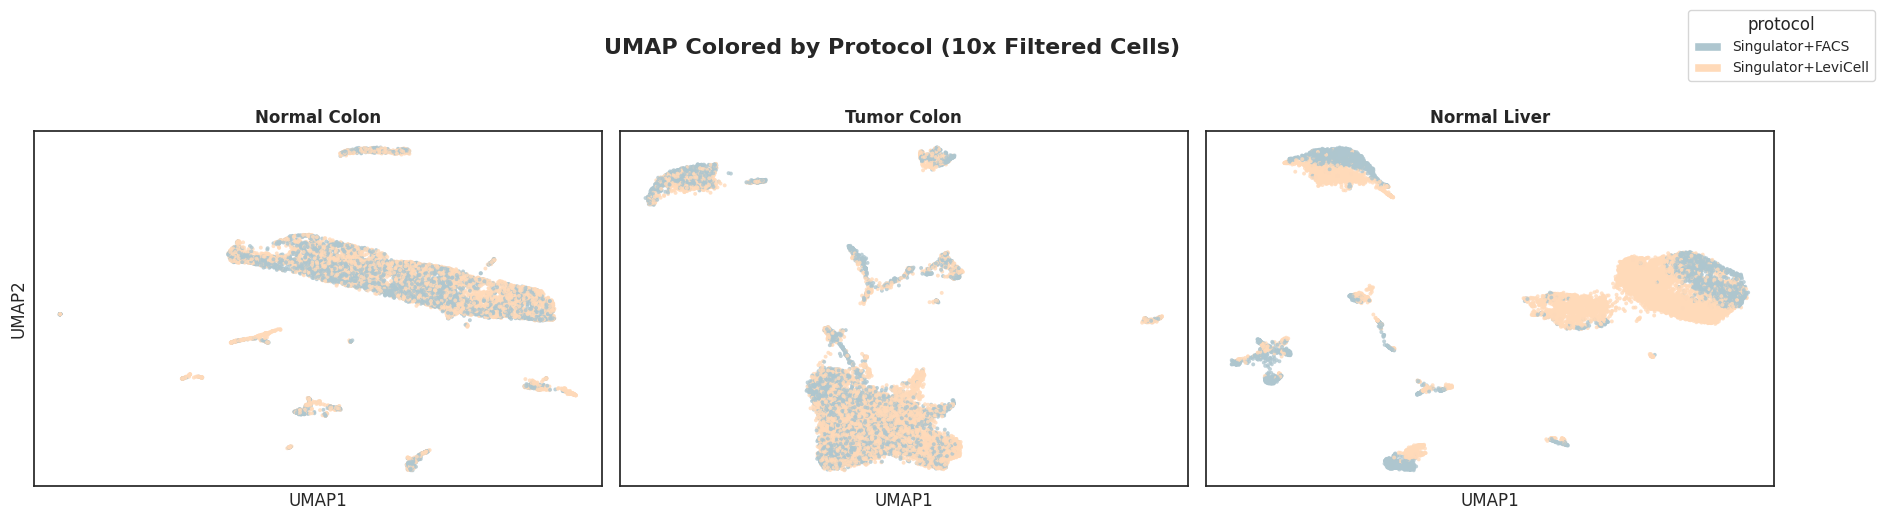

In [ ]:
# Plot UMAP colored by protocol
fig = utils.plot_umap_by_obs_feature(
    combined_by_tissue=combined_by_tissue,
    feature="protocol",
    color_palette=protocol_color_palette,
    title="UMAP Colored by Protocol (10x Filtered Cells)",
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "umap_by_protocol.png"), bbox_inches="tight"
)

### Plot by Library Size

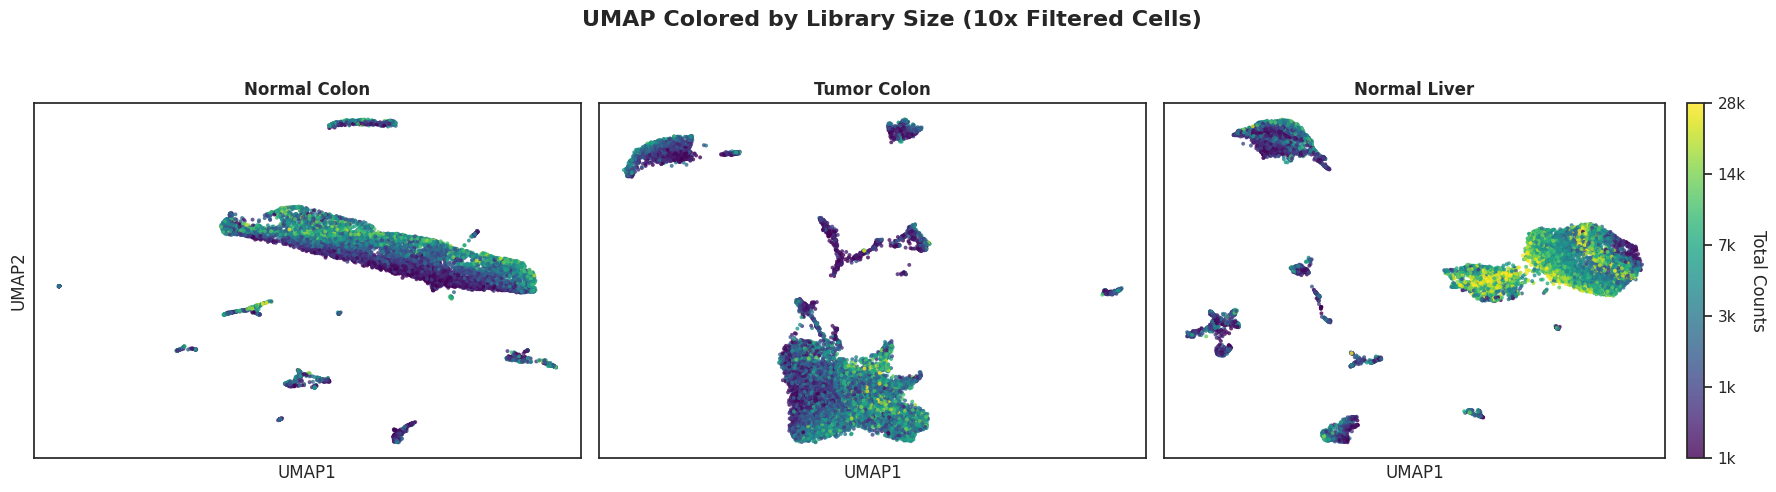

In [ ]:
# Plot UMAP colored by protocol
fig = utils.plot_umap_by_obs_feature(
    combined_by_tissue=combined_by_tissue,
    feature="total_counts",
    color_palette="viridis",
    log_scale=True,
    clip_values=(0.01, 0.99),
    title="UMAP Colored by Library Size (10x Filtered Cells)",
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "umap_by_library_size.png"), bbox_inches="tight"
)

### Plot by Leiden Cluster

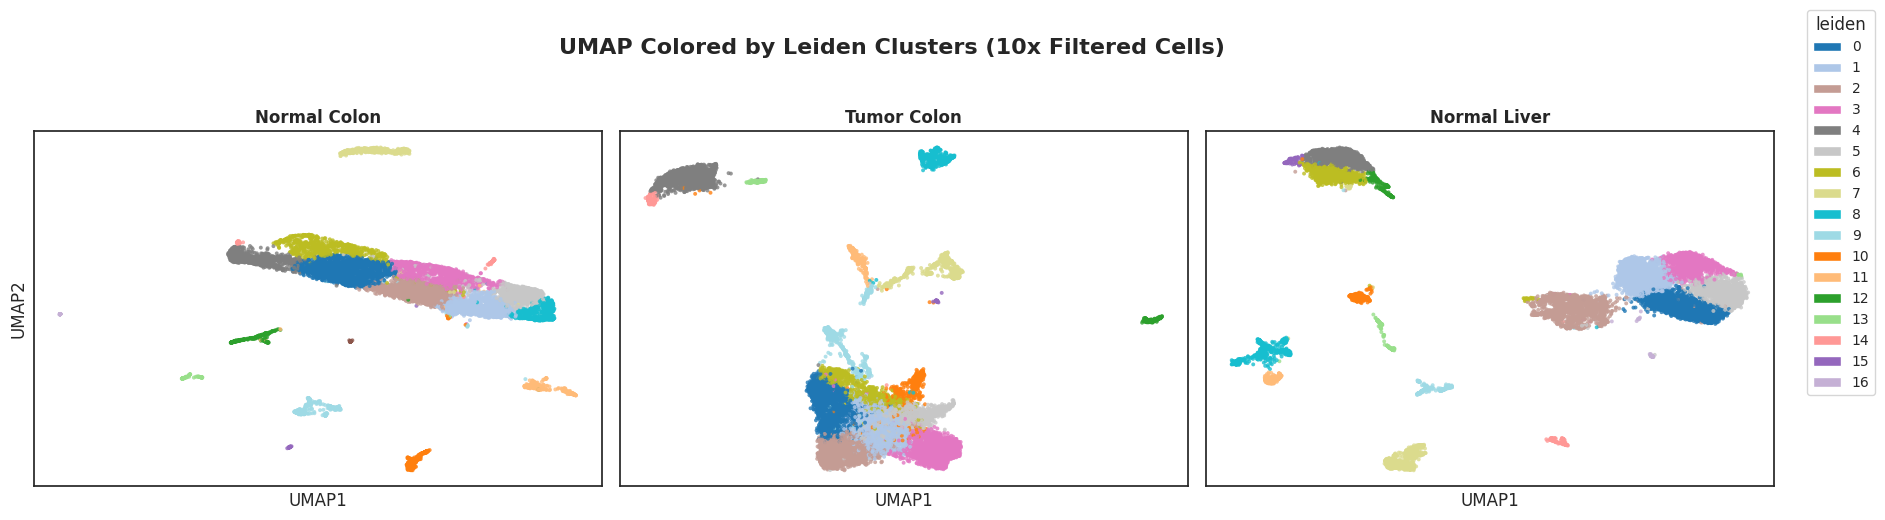

In [ ]:
# Plot UMAP colored by leiden cluster
fig = utils.plot_umap_by_obs_feature(
    combined_by_tissue=combined_by_tissue,
    feature="leiden",
    color_palette="tab20",
    title="UMAP Colored by Leiden Clusters (10x Filtered Cells)",
)

# Save the figure
fig.savefig(os.path.join(FIGURES_OUTPUT_DIR, "umap_by_leiden.png"), bbox_inches="tight")

### Cluster by Protocol Stackplots

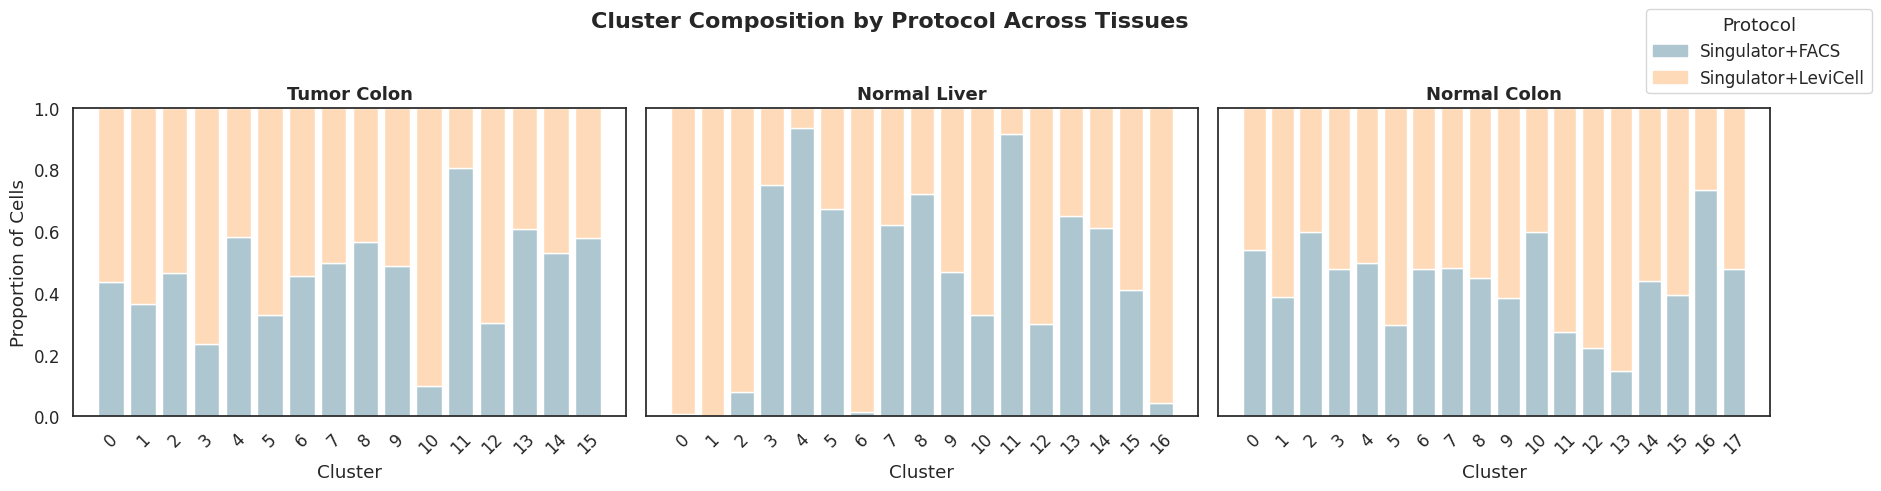

In [ ]:
fig = utils.plot_cluster_protocol_stackplots(
    combined_by_tissue=combined_by_tissue,
    cluster_key="leiden",
    protocol_key="protocol",
    protocol_color_palette=protocol_color_palette,
    tissue_order=set(adata_tissues),
)

fig.savefig(os.path.join(FIGURES_OUTPUT_DIR, "cluster_stackplot_cellranger_filtered.png"), bbox_inches="tight")

## Doublets

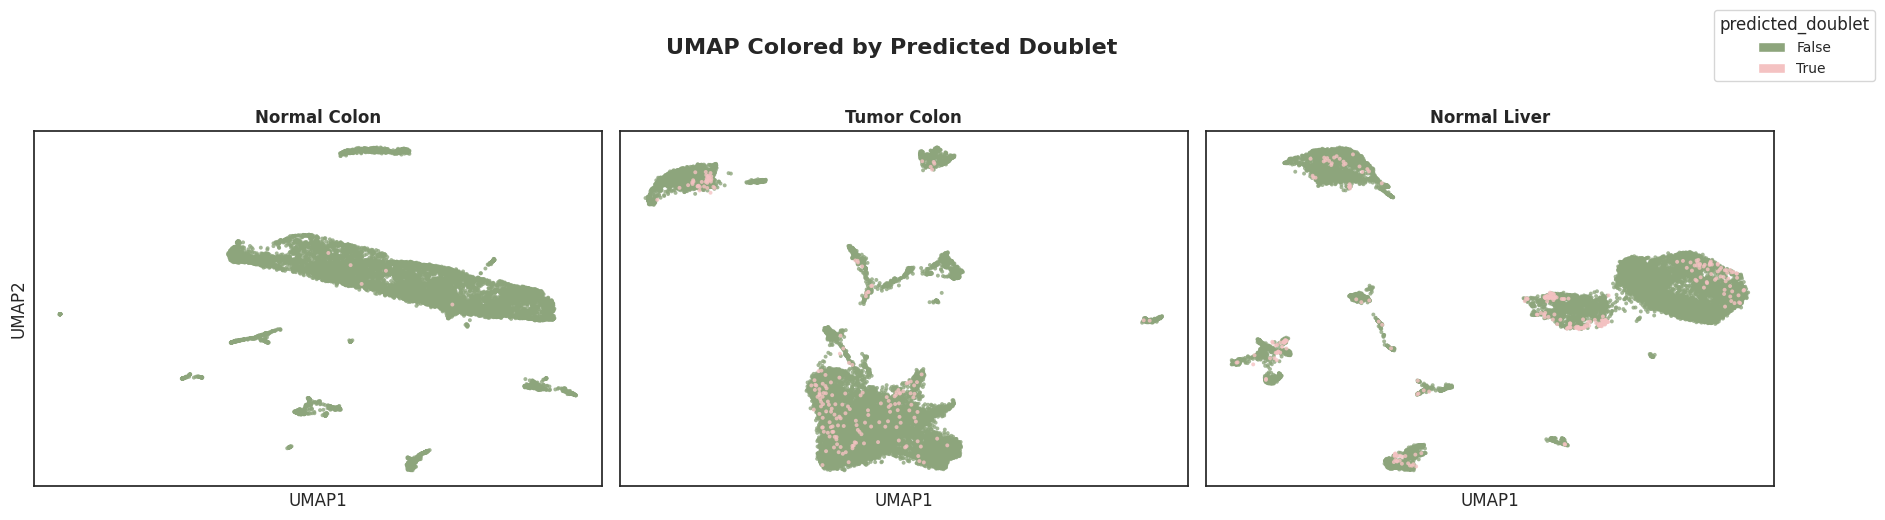

In [ ]:
doublet_palette = {
    False: "#8DA57C",  # pastel blue
    True: "#f4c2c2",  # pastel pink
}

fig = utils.plot_umap_by_obs_feature(
    combined_by_tissue=combined_by_tissue,
    feature="predicted_doublet",
    color_palette=doublet_palette,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "umap_by_predicted_doublets.png"),
    bbox_inches="tight",
)

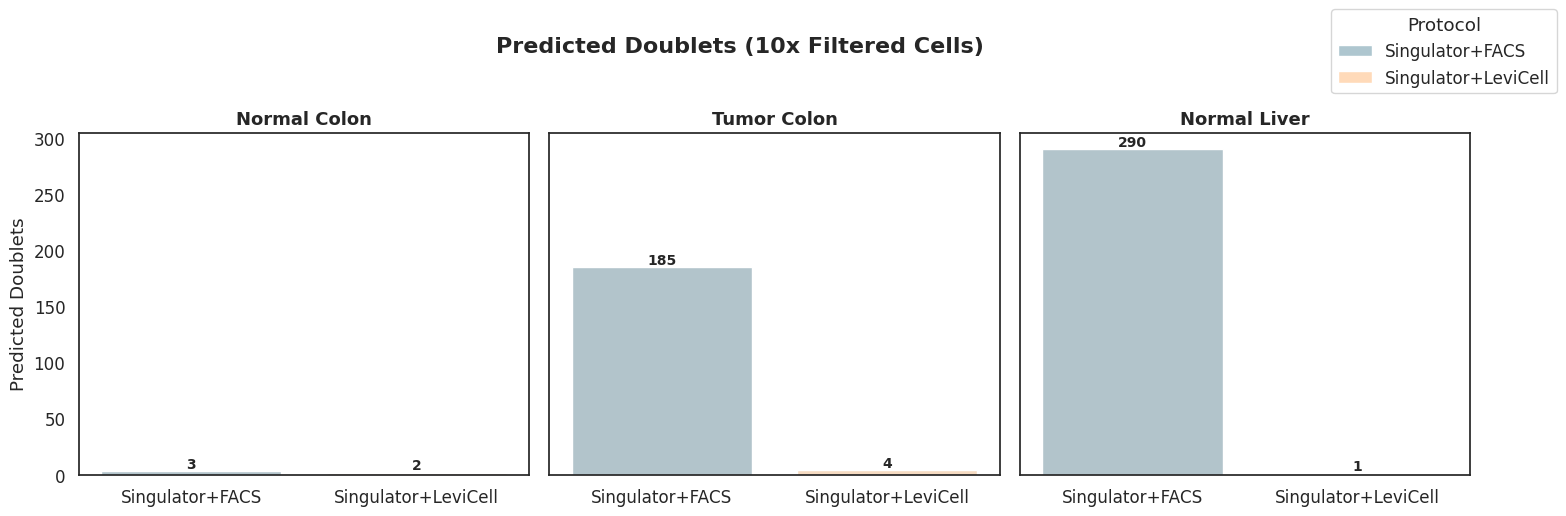

In [ ]:
# Plot number of cells
fig = utils.plot_scalar_metric(
    data_dict=adatas,
    metadata=adata_metadata,
    metric_func=lambda adata: int(adata.obs["predicted_doublet"].sum()),
    metric_label="Predicted Doublets",
    protocol_color_palette=protocol_color_palette,
    title = "Predicted Doublets (10x Filtered Cells)",
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "predicted_doublets_by_protocol.png"),
    bbox_inches="tight",
)

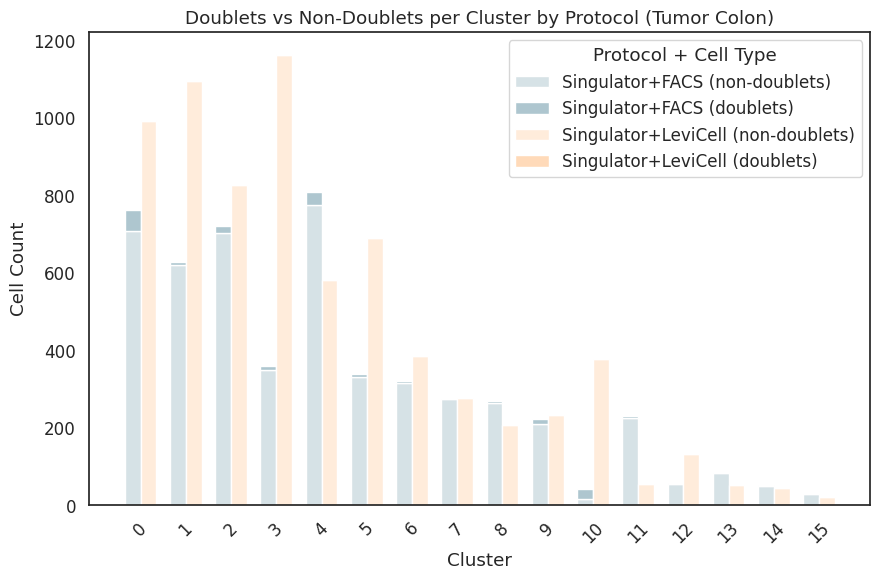

In [ ]:
fig = utils.plot_doublet_stack_by_cluster(
    combined_by_tissue=combined_by_tissue,
    tissue = "Tumor Colon",
    color_palette=protocol_color_palette,
)

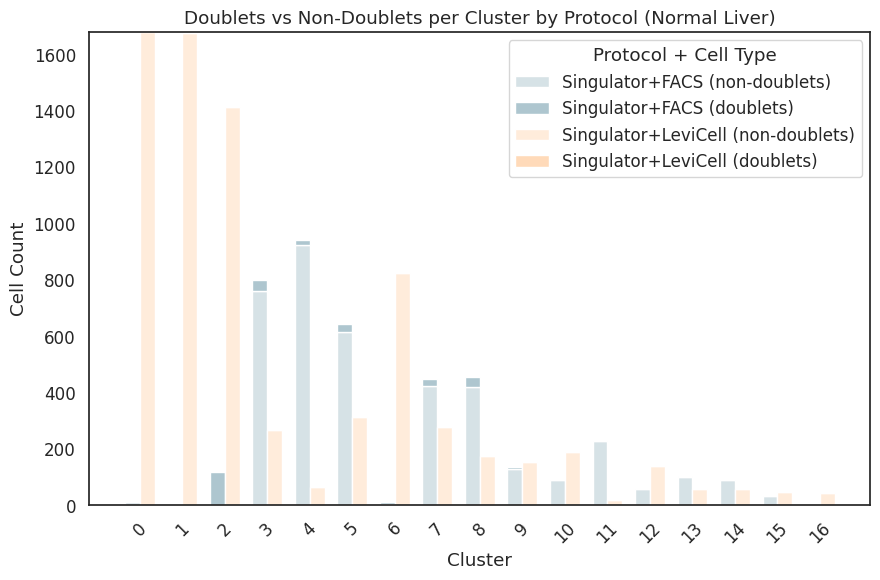

In [ ]:
fig = utils.plot_doublet_stack_by_cluster(
    combined_by_tissue=combined_by_tissue,
    tissue = "Normal Liver",
    color_palette=protocol_color_palette,
)

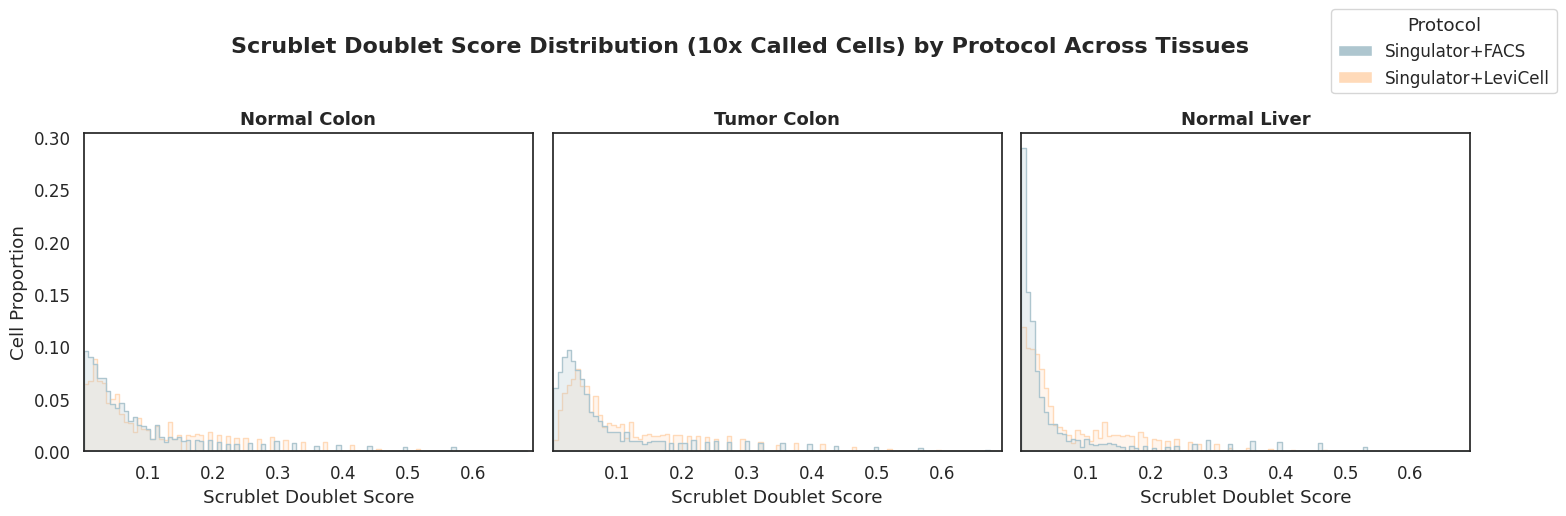

In [ ]:
# Plot doublet score distribution
fig = utils.plot_adata_metric_histogram(
    adatas=adatas,
    adata_metadata=adata_metadata,
    field="doublet_score",
    axis="obs",
    log_x=False,
    x_label="Scrublet Doublet Score",
    title="Scrublet Doublet Score Distribution (10x Called Cells) by Protocol Across Tissues",
    protocol_color_palette=protocol_color_palette,
    proportion=True,
)

# Save the figure
fig.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "scrublet_doublet_score_historgram.png"),
    bbox_inches="tight",
)

## Cell Typing

### Normal Liver

#### CellTypist

🔬 Input data has 11594 cells and 19346 genes
🔗 Matching reference genes in the model
🧬 2261 features used for prediction
⚖️ Scaling input data
🖋️ Predicting labels
✅ Prediction done!
🗳️ Majority voting the predictions
✅ Majority voting done!
... storing 'protocol' as categorical
... storing 'tissue' as categorical


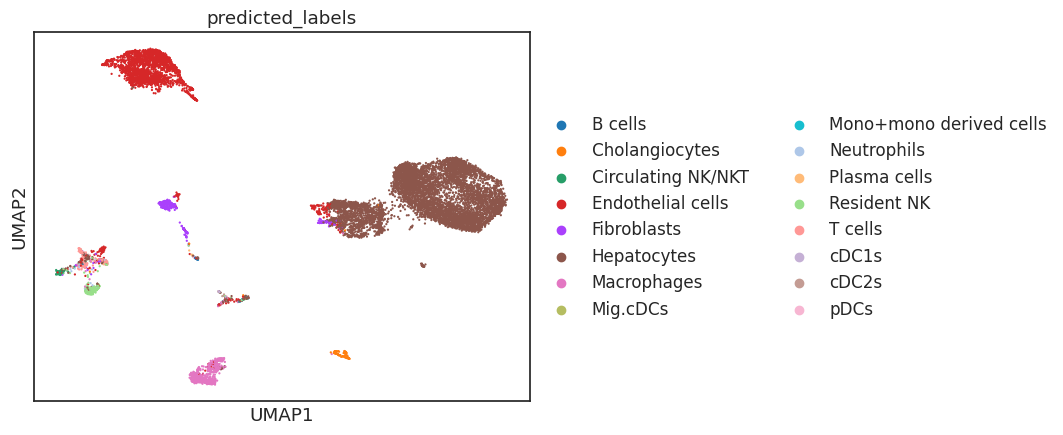

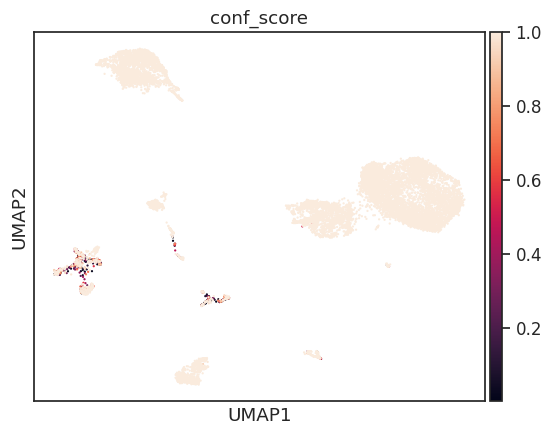

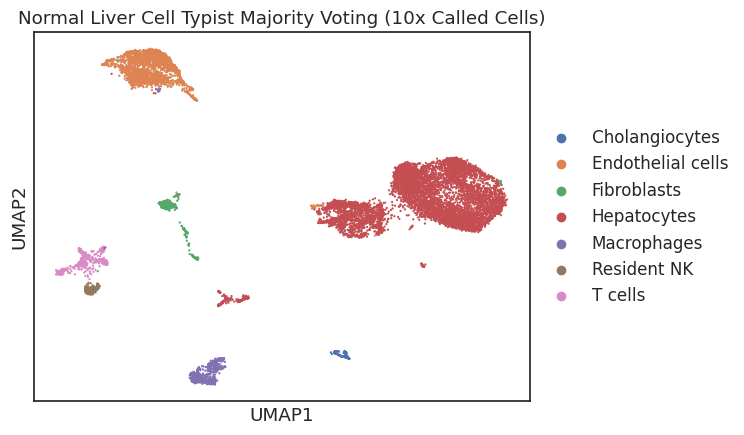

In [ ]:
import celltypist

normal_liver_cell_typist_input = combined_by_tissue["Normal Liver"].copy()
normal_liver_cell_typist_input.X = normal_liver_cell_typist_input.layers[
    "raw_data"
].copy()
sc.pp.normalize_total(normal_liver_cell_typist_input, target_sum=1e4, inplace=True)
sc.pp.log1p(normal_liver_cell_typist_input)

liver_cell_predictions = celltypist.annotate(
    normal_liver_cell_typist_input,
    model="Healthy_Human_Liver.pkl",
    majority_voting=True,
    over_clustering="leiden",
)

liver_cell_predictions_adata = liver_cell_predictions.to_adata()

majority_voting_output_path = os.path.join(
    FIGURES_OUTPUT_DIR, "majority_voting_output.png"
)

sc.pl.umap(liver_cell_predictions_adata, color="predicted_labels")
sc.pl.umap(liver_cell_predictions_adata, color="conf_score")
fig = sc.pl.umap(
    liver_cell_predictions_adata,
    color="majority_voting",
    title="Normal Liver Cell Typist Majority Voting (10x Called Cells)",
    return_fig=True,
)
fig.savefig(majority_voting_output_path, bbox_inches="tight")

#### Marker Genes

In [ ]:
liver_marker_dict = {
    "Hepatocytes": [
        "APOB",
        "CYP3A4",
    ],  # https://www.nature.com/articles/s42003-022-04046-9
    "Cholangiocytes": [
        "KRT19",
        "CFTR",
    ],  # https://pmc.ncbi.nlm.nih.gov/articles/PMC4315871/
    "Endothelial cells": [
        "PECAM1",
        "CDH5",
        "LDB2",
        "PTPRB",
    ],  # https://www.nature.com/articles/s41467-022-30633-9, CELL x GENE
    "Fibroblasts": [
        "COL1A2",
        "COL5A2",
        "COL6A3",
    ],  # https://pmc.ncbi.nlm.nih.gov/articles/PMC7444611/, CELL x Gene
    "Macrophages": [
        "CD68",
        "C1QA",
        "C1QB",
        "C1QC",
    ],  # https://pmc.ncbi.nlm.nih.gov/articles/PMC10153153/, https://pmc.ncbi.nlm.nih.gov/articles/PMC10849641/
    "Resident NK": [
        "KLRD1",
        "NCAM1",
    ],  # https://www.ncbi.nlm.nih.gov/gene/3824, https://www.frontiersin.org/journals/immunology/articles/10.3389/fimmu.2017.00892/full
    "T cells": [
        "CD3D",
        "CD3E",
        "CD3G",
        "CD2",
    ],  # https://pubmed.ncbi.nlm.nih.gov/39029632/
    # "B cells": [
    #     "BANK1",
    #     "IGHM",
    #     "CD19",
    #     "CD20",
    # ],  # BANK1 (B cell scaffold protein), IGHMis part of B cell receptor (IgM), CD19 and CD20 were not expressed in enough cells and were filtered out
    # # "B cells": ["CD19", "CD79A", "CD79B"], # https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-02064-6?utm_source=chatgpt.com
}

#### Plot Dotplot

dendrogram data not found (using key=dendrogram_majority_voting). Running `sc.tl.dendrogram` with default parameters. For fine tuning it is recommended to run `sc.tl.dendrogram` independently.


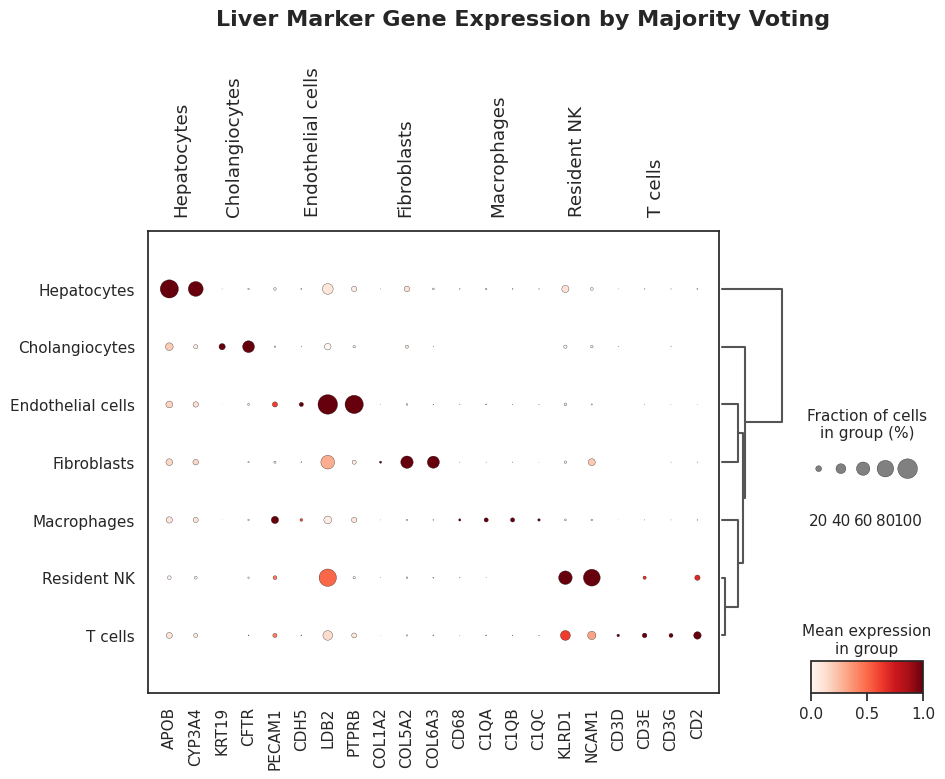

In [ ]:
# Create the dotplot
liver_dp = sc.pl.dotplot(
    liver_cell_predictions_adata,
    var_names=liver_marker_dict,
    groupby="majority_voting",
    standard_scale="var",
    color_map="Reds",
    figsize=(10, 6),
    dendrogram=True,
    show=False,
    return_fig=True,
)

# Set title and adjust layout
fig = liver_dp.get_axes()["mainplot_ax"].figure
fig.suptitle(
    "Liver Marker Gene Expression by Majority Voting",
    fontsize=16,
    weight="bold",
    y=1.25,
)
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Save figure
fig.savefig(os.path.join(FIGURES_OUTPUT_DIR, "normal_liver_marker_gene_dotplot.png"))

#### Plot Heatmap

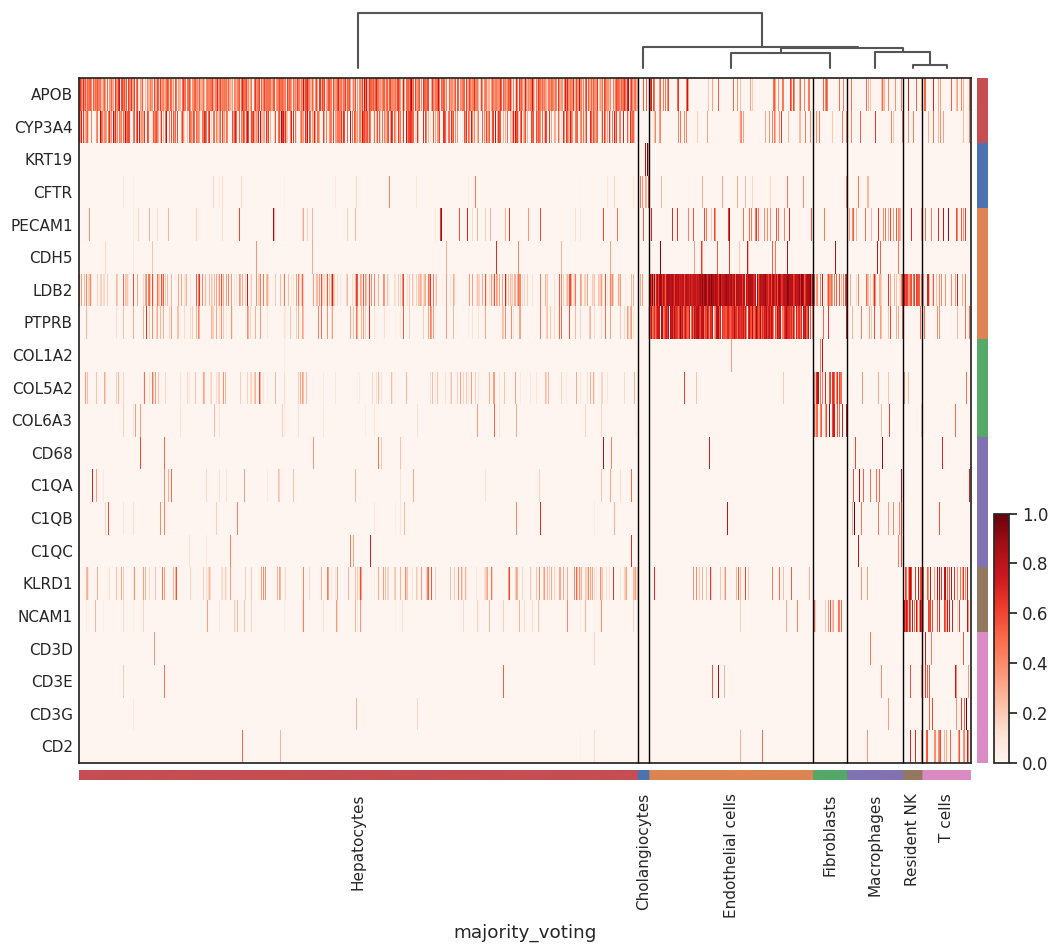

In [ ]:
import os

# Create and store the heatmap object
liver_hm = sc.pl.heatmap(
    liver_cell_predictions_adata,
    var_names=liver_marker_dict,
    groupby="majority_voting",
    use_raw=False,
    standard_scale="var",
    cmap="Reds",
    swap_axes=True,
    show_gene_labels=True,
    var_group_rotation=90,
    var_group_labels=liver_marker_dict.keys(),
    dendrogram=True,
    figsize=(12, 10),
    show=False,  # Prevent auto display
)


# Set title and adjust layout
fig = liver_dp.get_axes()["mainplot_ax"].figure
fig.suptitle(
    "Liver Marker Gene Expression by Majority Voting",
    fontsize=16,
    weight="bold",
    y=1.15,
)
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Save figure
fig.savefig(os.path.join(FIGURES_OUTPUT_DIR, "normal_liver_marker_gene_heatmap.png"))

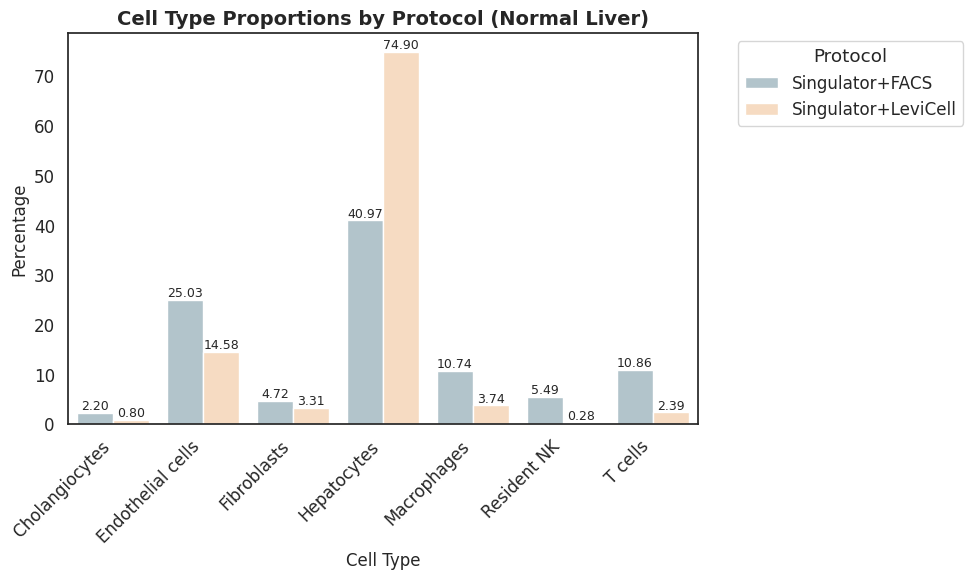

In [ ]:
# Plot cell type proportions by protocol for Normal Liver
fig = utils.plot_celltype_proportions_by_protocol(
    adata=liver_cell_predictions_adata,
    tissue="Normal Liver",
    protocol_color_palette=protocol_color_palette,
    annotate=True,
)

# Save the figure
fig.savefig(os.path.join(FIGURES_OUTPUT_DIR, "umap_by_leiden.png"), bbox_inches="tight")

#### Add annotations to original AnnData

In [ ]:
# Add annotations to original AnnData without a method

combined_by_tissue["Normal Liver"].obs["predicted_cell_type"] = (
    liver_cell_predictions_adata.obs["majority_voting"]
)

### Normal Colon

#### Functions

In [ ]:
def assign_celltypes_by_cluster_avg_expression(
    adata: sc.AnnData,
    cell_marker_genes: dict,
    cluster_key: str = "leiden",
) -> None:
    """
    Assigns a cell type to each cluster based on average expression of marker genes.

    Args:
        adata: Annotated data matrix (AnnData object).
        cell_marker_genes: Dict mapping cell types to marker gene lists.
        cluster_key: Key in `adata.obs` corresponding to cluster labels (e.g., 'leiden').

    Modifies:
        adata.obs["predicted_cell_type"]: Cluster-level cell type assignment.
    """
    # Set data matrix
    expr = adata.X
    gene_names = adata.var_names

    # Compute cluster-wise average expression
    clusters = adata.obs[cluster_key].astype(str)
    cluster_names = clusters.unique()

    cluster_means = []
    for cluster in cluster_names:
        idx = (clusters == cluster).values  # convert to NumPy array for sparse indexing
        avg_expr = np.asarray(expr[idx].mean(axis=0)).flatten()
        cluster_means.append(avg_expr)

    cluster_means = pd.DataFrame(
        cluster_means,
        index=cluster_names,
        columns=gene_names,
    )

    # Score each cluster for each cell type
    scores = {}
    for cell_type, markers in cell_marker_genes.items():
        valid_genes = [g for g in markers if g in cluster_means.columns]
        if not valid_genes:
            continue
        scores[cell_type] = cluster_means[valid_genes].mean(axis=1)

    scores_df = pd.DataFrame(scores)
    predicted = scores_df.idxmax(axis=1)

    # Map prediction back to each cell
    adata.obs["predicted_cell_type"] = clusters.map(predicted)

    return


In [ ]:
colon_marker_dict = {
    "Epithelial": ["EPCAM", "KRT8", "KRT18"],
    "Stromal": ["COL6A2", "COL6A1", "PLVAP", "COL1A1"],
    "Immune": [
        "PTPRC",
        "CD3E",
        "CD2",
        "CD3D",
        "CD3G",
        "FCER1G",
        "CSF1R",
        "CD14",
        "CD68",
        "CD38",
    ],
}

In [ ]:
def filter_marker_genes_by_adata(marker_dict: dict, adata: sc.AnnData) -> dict:
    """
    Filters a marker gene dictionary to include only genes present in adata.var_names.

    Args:
        marker_dict: Dictionary mapping cell types to lists of marker genes.
        adata: AnnData object whose var_names will be used to filter genes.

    Returns:
        A new dictionary with only valid genes per cell type.
    """
    valid_genes = set(adata.var_names)
    filtered_dict = {
        celltype: [gene for gene in genes if gene in valid_genes]
        for celltype, genes in marker_dict.items()
    }
    return filtered_dict


... storing 'protocol' as categorical
... storing 'tissue' as categorical
... storing 'predicted_cell_type' as categorical


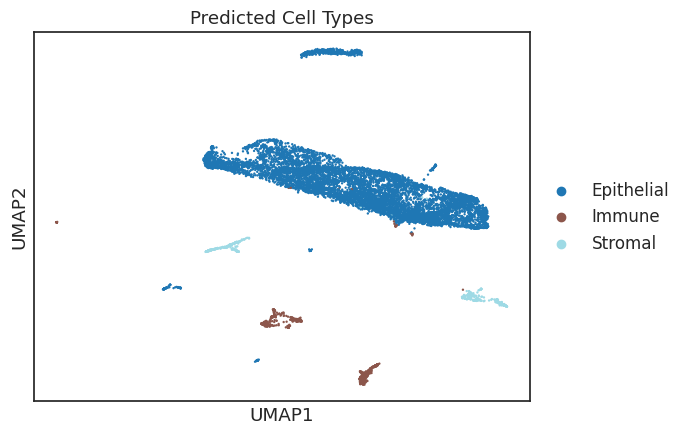

In [ ]:
# Assign cell types to the colon adata
assign_celltypes_by_cluster_avg_expression(
    adata=combined_by_tissue["Normal Colon"],
    cell_marker_genes=colon_marker_dict,
    cluster_key="leiden",
)

# Plot UMAP with predicted cell types for Normal Colon
sc.pl.umap(
    combined_by_tissue["Normal Colon"],
    color="predicted_cell_type",
    title="Predicted Cell Types",
    legend_loc="right margin",  # or "right margin"
    palette="tab20",
    frameon=True,
)

dendrogram data not found (using key=dendrogram_predicted_cell_type). Running `sc.tl.dendrogram` with default parameters. For fine tuning it is recommended to run `sc.tl.dendrogram` independently.


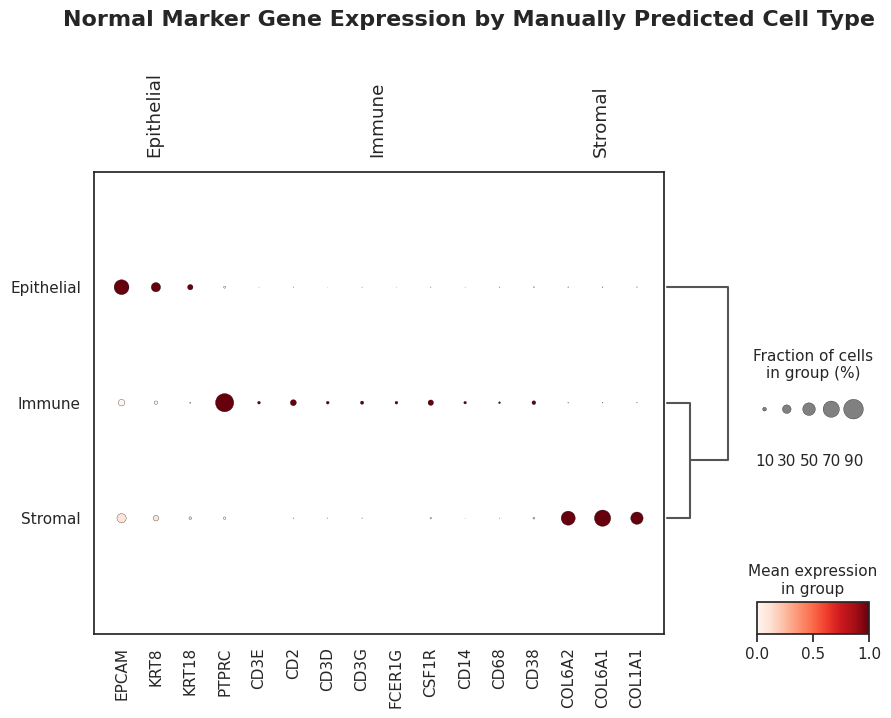

In [ ]:
filtered_colon_marker_dict = filter_marker_genes_by_adata(
    marker_dict=colon_marker_dict,
    adata=combined_by_tissue["Normal Colon"],
)

# Create the dotplot
normal_colon_dp = sc.pl.dotplot(
    combined_by_tissue["Normal Colon"],
    var_names=filtered_colon_marker_dict,
    groupby="predicted_cell_type",
    standard_scale="var",
    color_map="Reds",
    figsize=(10, 6),
    dendrogram=True,
    show=False,
    return_fig=True,
)

# Set title and adjust layout
fig = normal_colon_dp.get_axes()["a"].figure
fig.suptitle(
    "Normal Marker Gene Expression by Manually Predicted Cell Type",
    fontsize=16,
    weight="bold",
    y=1.15,
)
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Save figure
# fig.savefig(os.path.join(FIGURES_OUTPUT_DIR, "normal_liver_marker_gene_dotplot.png"))

In [ ]:
filtered_colon_marker_dict = filter_marker_genes_by_adata(
    marker_dict=colon_marker_dict,
    adata=combined_by_tissue["Normal Colon"],
)

# Create the dotplot
normal_colon_cluster_dp = sc.pl.dotplot(
    combined_by_tissue["Normal Colon"],
    var_names=filtered_colon_marker_dict,
    groupby="leiden",
    standard_scale="var",
    color_map="Reds",
    figsize=(10, 6),
    dendrogram=True,
    show=False,
    return_fig=True,
)

# Set title and adjust layout
fig = normal_colon_dp.get_axes()["a"].figure
fig.suptitle(
    "Normal Marker Gene Expression by Manually Predicted Cell Type",
    fontsize=16,
    weight="bold",
    y=1.15,
)
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Save figure
# fig.savefig(os.path.join(FIGURES_OUTPUT_DIR, "normal_liver_marker_gene_dotplot.png"))

NameError: name 'filter_marker_genes_by_adata' is not defined

... storing 'leiden_cell_type' as categorical
dendrogram data not found (using key=dendrogram_leiden_cell_type). Running `sc.tl.dendrogram` with default parameters. For fine tuning it is recommended to run `sc.tl.dendrogram` independently.
Groups are not reordered because the `groupby` categories and the `var_group_labels` are different.
categories: 0(Epithelial), 1(Epithelial), 2(Epithelial), etc.
var_group_labels: Epithelial, Stromal, Immune


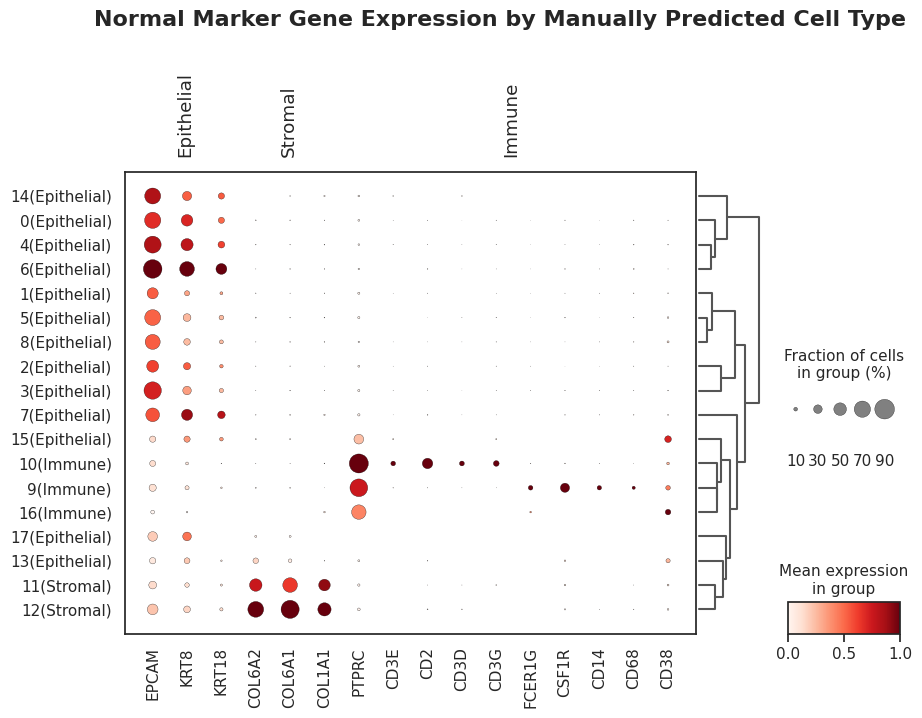

In [ ]:
normal_colon_adata = combined_by_tissue["Normal Colon"].copy()
normal_colon_adata.obs["leiden_cell_type"] = normal_colon_adata.obs["leiden"].astype(str) + " (" + normal_colon_adata.obs["predicted_cell_type"].astype(str) + ")"

filtered_colon_marker_dict = filter_marker_genes_by_adata(
    marker_dict=colon_marker_dict,
    adata=combined_by_tissue["Normal Colon"],
)

# Create the dotplot
normal_colon_dp = sc.pl.dotplot(
    normal_colon_adata,
    var_names=filtered_colon_marker_dict,
    groupby="leiden_cell_type",
    standard_scale="var",
    color_map="Reds",
    figsize=(10, 6),
    dendrogram=True,
    show=False,
    return_fig=True,
)

# Set title and adjust layout
fig = normal_colon_dp.get_axes()["mainplot_ax"].figure
fig.suptitle(
    "Normal Marker Gene Expression by Manually Predicted Cell Type",
    fontsize=16,
    weight="bold",
    y=1.15,
)
fig.tight_layout(rect=[0, 0, 1, 0.95])

# Save figure
# fig.savefig(os.path.join(FIGURES_OUTPUT_DIR, "normal_liver_marker_gene_dotplot.png"))

#### Plot Marker Gene Expression UMAPs

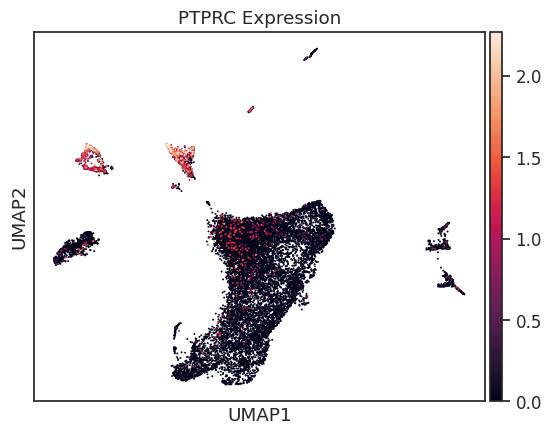

In [ ]:
# Immune Marker (PTPRC)
sc.pl.umap(
    combined_by_tissue["Normal Colon"],
    color="PTPRC",
    title="PTPRC Expression",
    legend_loc="right margin",  # or "right margin"
    palette="tab20",
    frameon=True,
    vmax="p99.9",
    sort_order=True,
)

In [ ]:
# Immune Marker (EPCAM)
sc.pl.umap(
    combined_by_tissue["Normal Colon"],
    color="EPCAM",
    title="EPCAM Expression",
    legend_loc="right margin",  # or "right margin"
    palette="tab20",
    frameon=True,
    vmax="p99.9",
    sort_order=True,
)

NameError: name 'sc' is not defined